In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay


In [12]:
# Wczytywanie danych opensmile
df = pd.read_parquet("irmas_opensmile_egemaps.parquet")
X = df.drop(columns=["label", "filepath"]).values 
y = df["label"].values

In [13]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# PCA i standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

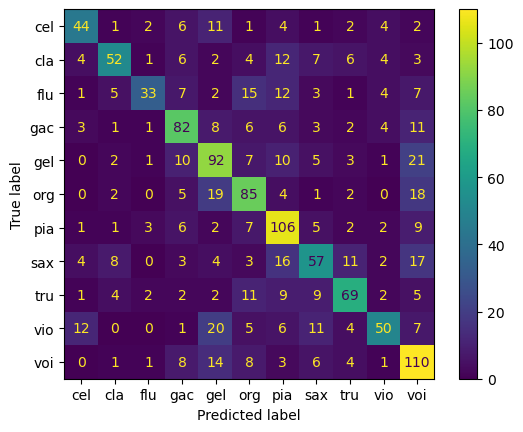

              precision    recall  f1-score   support

         cel       0.63      0.56      0.59        78
         cla       0.68      0.51      0.58       101
         flu       0.75      0.37      0.49        90
         gac       0.60      0.65      0.62       127
         gel       0.52      0.61      0.56       152
         org       0.56      0.62      0.59       136
         pia       0.56      0.74      0.64       144
         sax       0.53      0.46      0.49       125
         tru       0.65      0.59      0.62       116
         vio       0.68      0.43      0.53       116
         voi       0.52      0.71      0.60       156

    accuracy                           0.58      1341
   macro avg       0.61      0.57      0.57      1341
weighted avg       0.60      0.58      0.58      1341



In [15]:
# Klasyfikacja RandomForest
clf = RandomForestClassifier(n_estimators=100, max_features="sqrt" , random_state=42, n_jobs=-1)
clf.fit(X_train_scaled, y_train)
preds = clf.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

# show metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

# cross-validation


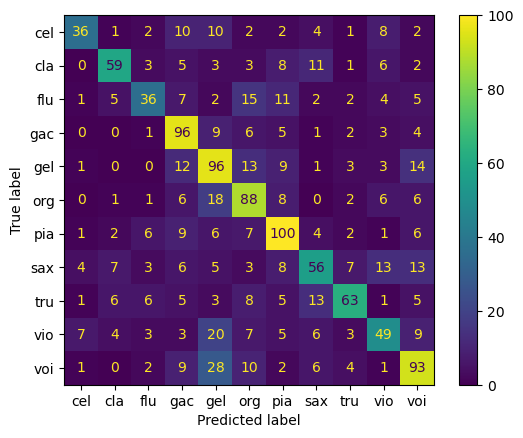

              precision    recall  f1-score   support

         cel       0.69      0.46      0.55        78
         cla       0.69      0.58      0.63       101
         flu       0.57      0.40      0.47        90
         gac       0.57      0.76      0.65       127
         gel       0.48      0.63      0.55       152
         org       0.54      0.65      0.59       136
         pia       0.61      0.69      0.65       144
         sax       0.54      0.45      0.49       125
         tru       0.70      0.54      0.61       116
         vio       0.52      0.42      0.46       116
         voi       0.58      0.60      0.59       156

    accuracy                           0.58      1341
   macro avg       0.59      0.56      0.57      1341
weighted avg       0.58      0.58      0.57      1341



In [17]:
# druga metoda klasyfikacji
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_scaled, y_train)
svm_preds = svm_clf.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, svm_preds)
plt.show()
print(classification_report(y_test, svm_preds))

[I 2025-12-11 15:51:21,918] A new study created in memory with name: no-name-74a62dd0-1539-43af-aaf0-ae7589f94c67
[I 2025-12-11 15:51:22,688] Trial 0 finished with value: 0.575689783743475 and parameters: {'n_estimators': 289, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.575689783743475.
[I 2025-12-11 15:51:28,119] Trial 1 finished with value: 0.5771812080536913 and parameters: {'n_estimators': 282, 'max_features': None}. Best is trial 1 with value: 0.5771812080536913.
[I 2025-12-11 15:51:28,695] Trial 2 finished with value: 0.5771812080536913 and parameters: {'n_estimators': 279, 'max_features': 'log2'}. Best is trial 1 with value: 0.5771812080536913.
[I 2025-12-11 15:51:28,939] Trial 3 finished with value: 0.56972408650261 and parameters: {'n_estimators': 75, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5771812080536913.
[I 2025-12-11 15:51:29,139] Trial 4 finished with value: 0.5727069351230425 and parameters: {'n_estimators': 53, 'max_features': 'sqrt'}. Best is

Best hyperparameters:  {'n_estimators': 220, 'max_features': 'log2'}


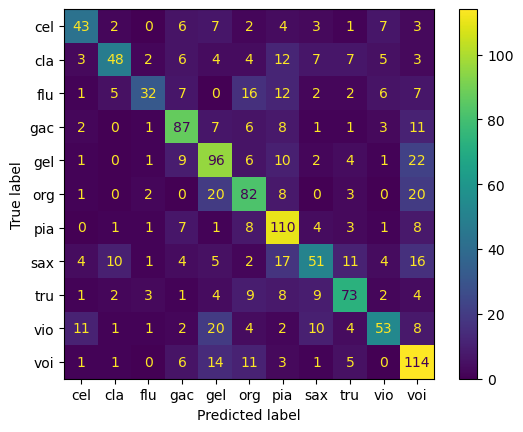

              precision    recall  f1-score   support

         cel       0.63      0.55      0.59        78
         cla       0.69      0.48      0.56       101
         flu       0.73      0.36      0.48        90
         gac       0.64      0.69      0.66       127
         gel       0.54      0.63      0.58       152
         org       0.55      0.60      0.57       136
         pia       0.57      0.76      0.65       144
         sax       0.57      0.41      0.47       125
         tru       0.64      0.63      0.63       116
         vio       0.65      0.46      0.54       116
         voi       0.53      0.73      0.61       156

    accuracy                           0.59      1341
   macro avg       0.61      0.57      0.58      1341
weighted avg       0.60      0.59      0.58      1341



In [16]:
# optuna hyperparameter tuning
import optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test, preds)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters: ", study.best_params)
# retrain with best hyperparameters
best_clf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_clf.fit(X_train, y_train)
best_preds = best_clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, best_preds)
plt.show()
print(classification_report(y_test, best_preds))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


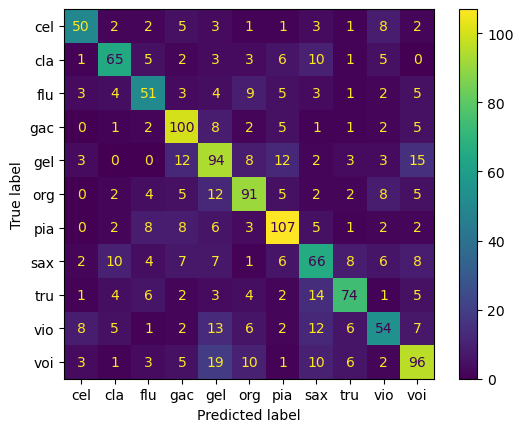

              precision    recall  f1-score   support

         cel       0.70      0.64      0.67        78
         cla       0.68      0.64      0.66       101
         flu       0.59      0.57      0.58        90
         gac       0.66      0.79      0.72       127
         gel       0.55      0.62      0.58       152
         org       0.66      0.67      0.66       136
         pia       0.70      0.74      0.72       144
         sax       0.52      0.53      0.52       125
         tru       0.71      0.64      0.67       116
         vio       0.58      0.47      0.52       116
         voi       0.64      0.62      0.63       156

    accuracy                           0.63      1341
   macro avg       0.64      0.63      0.63      1341
weighted avg       0.63      0.63      0.63      1341



In [18]:
# tuning hyperparameters with GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
print("Best hyperparameters: ", grid.best_params_)
grid_preds = grid.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, grid_preds)
plt.show()
print(classification_report(y_test, grid_preds))